# Activity: Improving sentiment analysis with convolutional layers

## Objective

In this activity, you will extend the baseline RNN sentiment classifier by adding **convolutional layers** to create a hybrid CNN-RNN architecture. Convolutional layers can capture local n-gram patterns (like "not good" or "very happy") before the recurrent layers process the sequence.

**Your tasks:**
1. Run the baseline GRU model and note its performance
2. Modify the model architecture to include convolutional layers
3. Train your CNN-RNN hybrid model
4. Compare the results to the baseline

---

## Key terms

- **Tokenization**: Splitting text into individual units (tokens), typically words. For example, "I love this!" becomes `["i", "love", "this"]`. This is the first step in converting text to a format neural networks can process.

- **Embedding**: A dense vector representation of a token. Instead of one-hot encoding (sparse, high-dimensional), embeddings map each word to a fixed-size vector (e.g., 100 dimensions) where similar words have similar vectors. We use pretrained GloVe embeddings trained on Twitter data.

- **LSTM/GRU**: Variants of RNNs designed to handle long sequences better than SimpleRNN. They use "gates" to control information flow, solving the vanishing gradient problem. **GRU** (Gated Recurrent Unit) has 2 gates and is simpler; **LSTM** (Long Short-Term Memory) has 3 gates and more parameters. Both work well in practice — we use GRU here for efficiency.


    ```
                        ┌─────────────────────────────────────┐
                        │            GRU Unit                 │
                        │                                     │
        h(t-1) ────────▶│  ┌────────┐      ┌────────┐         │────────▶ h(t) 
    (previous        │  │ Reset  │      │ Update │         │        (next
        hidden          │  │ Gate   │      │ Gate   │         │        hidden 
        state)          │  └────┬───┘      └────┬───┘         │        state)
                        │       │               │             │
                        │       ▼               ▼             │
                        │    [Decide what    [Decide how      │
                        │     to forget]      much to         │
                        │                     update]         │
                        └─────────────────────────────────────┘
                                        ▲
                                        │
                                    x(t)
                                (input at
                                timestep t)
    ```


- **Reset gate**: Controls how much h(t-1) influences the candidate, Gates are **dynamic weights** (0-1) — one per hidden unit — computed fresh for each input. Depend on **both** the previous hidden state AND the current input embedding.
- **Update gate**: Controls how much h(t-1) vs candidate goes into the final output. Also computed from previous hidden state + current input, just with different learned weights.

    ```
    h(t-1) ──┬──[reset weights]──▶ compute candidate h̃(t)
            │                            │
            │                            ▼
            └────[update weights]────▶ blend ──▶ h(t)
    ```

- **Bidirectional Recurrent Layers**: Processing a sequence in both directions (forward and backward) and combining the results. This allows the model to use context from both before AND after each word, improving understanding. A bidirectional GRU with 64 units outputs 128 features (64 forward + 64 backward).

## External tools & resources

- **NLTK TweetTokenizer**: A tokenizer designed specifically for social media text. Handles emoticons, hashtags, mentions, and normalizes repeated characters (e.g., "sooooo" → "sooo").

- **NLTK Stopwords**: A curated list of common English words (e.g., "the", "is", "at") that are filtered out during preprocessing to reduce noise.

- **GloVe Embeddings**: Pretrained word vectors from Stanford NLP. We use the Twitter-specific version (27B tokens, 100 dimensions) which captures word relationships learned from tweets.

---

## Notebook setup

### Imports

In [ ]:
import os
import re
import zipfile
import urllib.request
from collections import Counter

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, Dense, GRU, Dropout, Bidirectional, SpatialDropout1D
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize

# Download NLTK resources
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

### Configuration

In [ ]:
stop_words = set(stopwords.words('english'))
tweet_tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)

## 1. Data preparation

### 1.1. Load

In [2]:
df = pd.read_parquet('../data/twitter-2016.parquet')
df.head()

,id,name,score,text
0,638060586258038784,michael jackson,0,05 Beat it - Michael Jackson - Thriller (25th ...
1,638061181823922176,michael jackson,1,Jay Z joins Instagram with nostalgic tribute t...
2,638083821364244480,michael jackson,0,Michael Jackson: Bad 25th Anniversary Edition ...
3,638091450132078593,michael jackson,1,I liked a @YouTube video http://t.co/AaR3pjp2P...
4,638125563790557184,michael jackson,1,18th anniv of Princess Diana's death. I still ...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30467 entries, 0 to 30466
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      30467 non-null  int64 
 1   name    30467 non-null  object
 2   score   30467 non-null  int64 
 3   text    30467 non-null  object
dtypes: int64(2), object(2)
memory usage: 952.2+ KB


### 1.2. Clean

In [ ]:
# Clean data - drop rows with missing scores
df_clean = df.dropna(subset=['score']).copy()
df_clean['score'] = df_clean['score'].astype(int)

# Shift scores to 0-based index: [-2,-1,0,1,2] -> [0,1,2,3,4]
score_min = df_clean['score'].min()
df_clean['score_shifted'] = df_clean['score'] - score_min

print(f'Cleaned dataset: {len(df_clean):,} rows ({len(df) - len(df_clean):,} dropped)')
print(f'Score distribution: {df_clean["score_shifted"].value_counts().sort_index().to_dict()}')

,text,tokens,score
0,05 Beat it - Michael Jackson - Thriller (25th ...,"[05, beat, michael, jackson, thriller, 25th, a...",0
1,Jay Z joins Instagram with nostalgic tribute t...,"[jay, joins, instagram, nostalgic, tribute, mi...",1
2,Michael Jackson: Bad 25th Anniversary Edition ...,"[michael, jackson, bad, 25th, anniversary, edi...",0
3,I liked a @YouTube video http://t.co/AaR3pjp2P...,"[liked, video, one, direction, singing, man, m...",1
4,18th anniv of Princess Diana's death. I still ...,"[18th, anniv, princess, diana's, death, still,...",1


### 1.3. Tokenize

In [ ]:
# Clean and tokenize text using NLTK's TweetTokenizer
def clean_text(text):
    '''Clean and tokenize tweet text using TweetTokenizer.'''

    if not isinstance(text, str):
        return []

    # Remove URLs before tokenizing
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # TweetTokenizer handles: lowercase, @mentions, repeated chars (e.g., sooooo -> sooo)
    tokens = tweet_tokenizer.tokenize(text)

    # Remove stopwords and single characters
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]

    return tokens

# Apply tokenization
df_clean['tokens'] = df_clean['text'].apply(clean_text)
df_clean[['text', 'tokens', 'score']].head()

### 1.4. Build vocabulary

In [ ]:
# Build vocabulary
def build_vocab(token_lists, min_freq=2):
    '''Build vocabulary from token lists.'''

    counter = Counter()

    for tokens in token_lists:
        counter.update(tokens)
    
    # Filter by minimum frequency and create vocab
    vocab = {'<PAD>': 0, '<UNK>': 1}

    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)

    return vocab

vocab = build_vocab(df_clean['tokens'])
print(f'Vocabulary size: {len(vocab)}')

Vocabulary size: 14965


### 1.5. Convert to indices

In [ ]:
def tokens_to_indices(tokens_list, vocab, max_len=50):
    '''Convert token lists to padded index sequences.'''

    sequences = []

    for tokens in tokens_list:
        indices = [vocab.get(token, vocab['<UNK>']) for token in tokens]
        sequences.append(indices)

    # Pad sequences to max_len
    return pad_sequences(sequences, maxlen=max_len, padding='post', value=vocab['<PAD>'])

# Convert all data to indices
max_len = 50
X = tokens_to_indices(df_clean['tokens'].tolist(), vocab, max_len)
y = df_clean['score_shifted'].values

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

### 1.6. Train/test split

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'Score distribution (train): {Counter(y_train)}')

X_train shape: (24373, 50)
y_train shape: (24373,)
Score distribution (train): Counter({2: 10362, 3: 10249, 1: 2714, 4: 809, 0: 239})


## 2. Prepare GloVe embeddings

GloVe (Global Vectors) provides pretrained word embeddings trained on large text corpora. Using these gives our model a head start - words already have meaningful representations instead of random vectors.

### 2.1. Download embeddings

In [ ]:
# Download GloVe embeddings (Twitter-specific, 100d)
glove_dir = '../data'
glove_file = os.path.join(glove_dir, 'glove.twitter.27B.100d.txt')
glove_zip = os.path.join(glove_dir, 'glove.twitter.27B.zip')
glove_url = 'https://nlp.stanford.edu/data/glove.twitter.27B.zip'

if not os.path.exists(glove_file):

    print('Downloading GloVe embeddings...')
    urllib.request.urlretrieve(glove_url, glove_zip)

    print('Extracting...')
    with zipfile.ZipFile(glove_zip, 'r') as zip_ref:
        zip_ref.extract('glove.twitter.27B.100d.txt', glove_dir)

    os.remove(glove_zip)
    print('Done!')

else:
    print(f'GloVe file already exists: {glove_file}')

GloVe file already exists: ../data/glove.twitter.27B.100d.txt


### 2.2. Load embeddings into dictionary

In [ ]:
# Load GloVe vectors into dictionary
print('Loading GloVe vectors...')

glove_vectors = {}

with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:

        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        glove_vectors[word] = vector

print(f'Loaded {len(glove_vectors):,} word vectors')
print(f'Embedding dimension: {len(next(iter(glove_vectors.values())))}')

Loading GloVe vectors...
Loaded 1,193,514 word vectors
Embedding dimension: 100


### 2.3. Create embedding look-up table for our vocabulary

In [ ]:
# Create embedding matrix for our vocabulary
embedding_dim = 100  # GloVe Twitter uses 100d
vocab_size = len(vocab)

embedding_matrix = np.zeros((vocab_size, embedding_dim))
words_found = 0

for word, idx in vocab.items():
    if word in glove_vectors:
        embedding_matrix[idx] = glove_vectors[word]
        words_found += 1

    else:
        # Random initialization for words not in GloVe
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

coverage = words_found / vocab_size
print(f'Vocabulary coverage: {words_found:,} / {vocab_size:,} ({coverage:.1%})')
print(f'Embedding matrix shape: {embedding_matrix.shape}')

Vocabulary coverage: 12,976 / 14,965 (86.7%)
Embedding matrix shape: (14965, 100)


## 3. Baseline: Bidirectional GRU model

First, let's establish our baseline performance with a pure recurrent architecture.

### 3.1. Build model

In [ ]:
# Model hyperparameters
hidden_dim = 64
output_dim = len(set(y_train))
dropout = 0.3            # Spatial dropout rate
recurrent_dropout = 0.3  # Dropout on recurrent connections
l2_reg = 0.01            # L2 regularization strength
learning_rate = 0.0001   # Lower LR for fine-tuning embeddings

# Build Bidirectional GRU model with pretrained GloVe embeddings
model = Sequential([
    Embedding(
        vocab_size, 
        embedding_dim,
        weights=[embedding_matrix],
        trainable=True  # Fine-tune embeddings with lower learning rate
    ),
    SpatialDropout1D(dropout),
    Bidirectional(GRU(hidden_dim, recurrent_dropout=recurrent_dropout, return_sequences=True)),
    Bidirectional(GRU(hidden_dim // 2, recurrent_dropout=recurrent_dropout)),  # Second layer, smaller
    Dropout(dropout),
    Dense(output_dim, activation='softmax', kernel_regularizer=l2(l2_reg))
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1496500   
                                                                 
 spatial_dropout1d (Spatial  (None, None, 100)         0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, None, 128)         63744     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                31104     
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                        

### 3.2. Define training callbacks

In [16]:
callbacks = [
    ModelCheckpoint(
        '../models/rnn_classifier.keras',
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    TensorBoard(
        log_dir='../logs/rnn_classifier',
        histogram_freq=1,
        write_graph=True
    )
]

### 3.3. Calculate class weights

In [17]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print(f'Class weights: {class_weight_dict}')

Class weights: {0: 20.39581589958159, 1: 1.7960943257184967, 2: 0.47043041883806214, 3: 0.47561713337886624, 4: 6.025463535228678}


### 3.4. Train the model

In [ ]:
# Training with class weighting and early stopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=callbacks
)

Epoch 1/30


I0000 00:00:1770934211.831974 1510527 service.cc:145] XLA service 0x7cc584144290 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770934211.832054 1510527 service.cc:153]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1770934211.924345 1510527 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


381/381 [==============================] - ETA: 0s - loss: 1.7151 - accuracy: 0.1988
Epoch 1: val_accuracy improved from -inf to 0.28356, saving model to ../models/rnn_classifier.keras
381/381 [==============================] - 88s 117ms/step - loss: 1.7151 - accuracy: 0.1988 - val_loss: 1.6417 - val_accuracy: 0.2836
Epoch 2/30
381/381 [==============================] - ETA: 0s - loss: 1.6190 - accuracy: 0.2350
Epoch 2: val_accuracy improved from 0.28356 to 0.29833, saving model to ../models/rnn_classifier.keras
381/381 [==============================] - 31s 82ms/step - loss: 1.6190 - accuracy: 0.2350 - val_loss: 1.5609 - val_accuracy: 0.2983
Epoch 3/30
381/381 [==============================] - ETA: 0s - loss: 1.5272 - accuracy: 0.2526
Epoch 3: val_accuracy did not improve from 0.29833
381/381 [==============================] - 30s 79ms/step - loss: 1.5272 - accuracy: 0.2526 - val_loss: 1.5832 - val_accuracy: 0.1666
Epoch 4/30
381/381 [==============================] - ETA: 0s - loss:

## 4. Baseline evaluation

Record the baseline metrics below so you can compare them to your CNN-RNN model later.

### 4.1. Make test set predictions

In [21]:
# Load best model and get predictions
model = tf.keras.models.load_model('../models/rnn_classifier.keras')

# Get predicted probabilities and classes
y_prob = model.predict(X_test)
y_pred = y_prob.argmax(axis=1)

# Class labels
class_names = ['-2', '-1', '0', '1', '2']
n_classes = len(class_names)

print(f'Test samples: {len(y_test)}')
print(f'Prediction distribution:')
print(f'  Actual:    {Counter(y_test)}')
print(f'  Predicted: {Counter(y_pred)}')

191/191 [==============================] - 6s 16ms/step
Test samples: 6094
Prediction distribution:
  Actual:    Counter({2: 2591, 3: 2563, 1: 678, 4: 202, 0: 60})
  Predicted: Counter({2: 2083, 3: 1856, 1: 1150, 4: 856, 0: 149})


### 4.2. Per-class accuracy

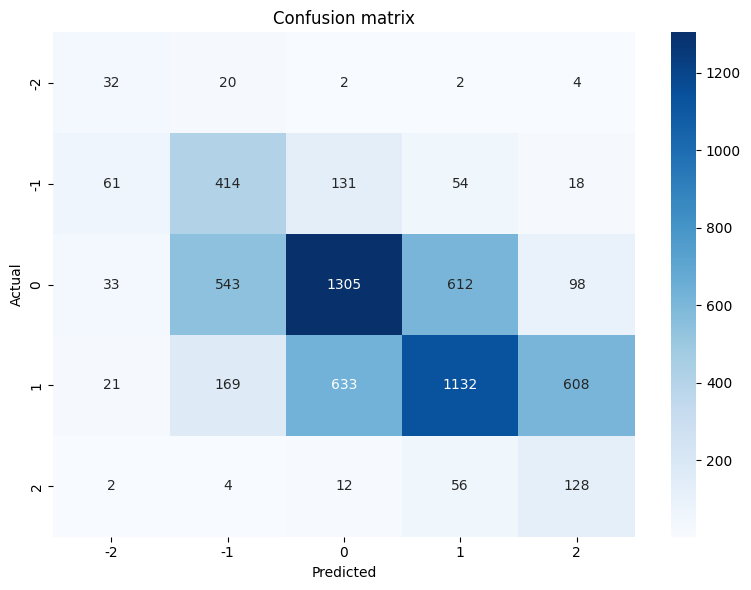

In [ ]:
# Per-class accuracy table
per_class_stats = []

for i, class_name in enumerate(class_names):
    mask = y_test == i
    n_samples = mask.sum()
    n_correct = (y_pred[mask] == i).sum()
    accuracy = n_correct / n_samples if n_samples > 0 else 0
    
    per_class_stats.append({
        'Class': class_name,
        'Samples': n_samples,
        'Correct': n_correct,
        'Accuracy': f'{accuracy:.1%}'
    })

# Add overall accuracy
overall_acc = (y_pred == y_test).mean()
per_class_stats.append({
    'Class': 'Overall',
    'Samples': len(y_test),
    'Correct': (y_pred == y_test).sum(),
    'Accuracy': f'{overall_acc:.1%}'
})

accuracy_df = pd.DataFrame(per_class_stats)
accuracy_df

### 4.3. Confusion matrix

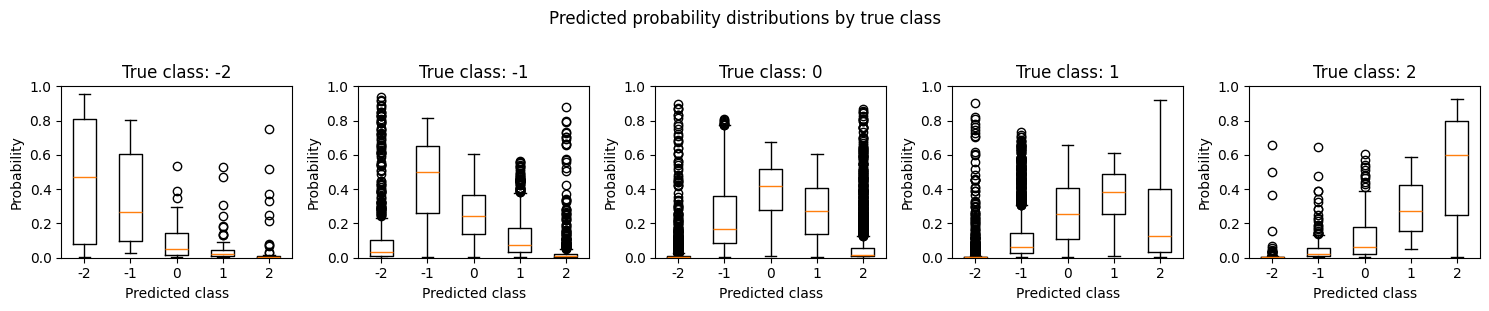

In [ ]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))

ax.set_title('Confusion matrix')

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(
    cm, 
    annot=True, fmt='d', cmap='Blues', 
    xticklabels=class_names, yticklabels=class_names, ax=ax
)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

### 4.4. Predicted probability distributions by class

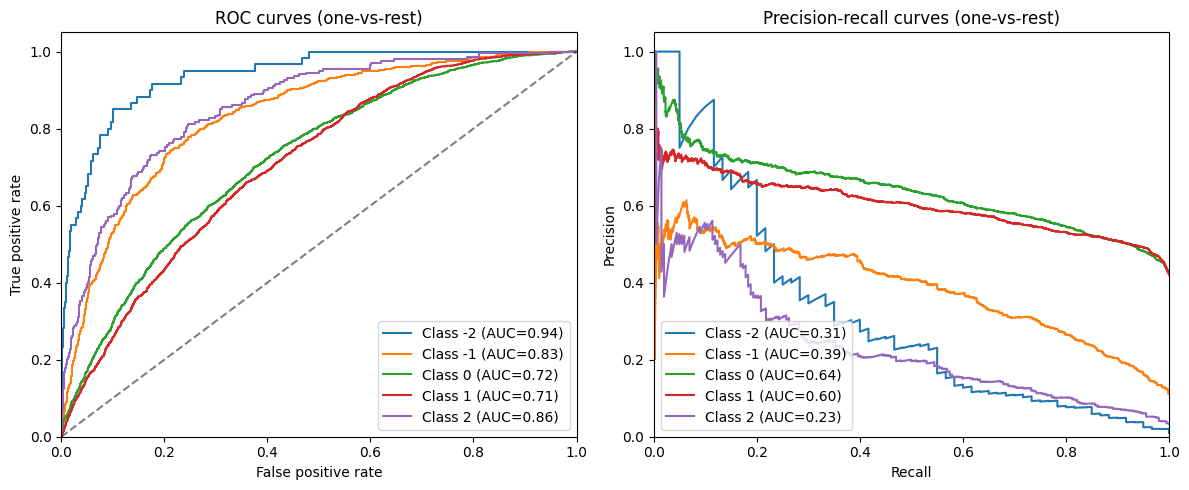

In [ ]:
# Predicted probability distributions for each true class
fig, axes = plt.subplots(1, n_classes, figsize=(10, 2.5))

plt.suptitle('Predicted probability distributions by true class', y=1.02)

for i, class_name in enumerate(class_names):

    # Get predictions for samples of this true class
    mask = y_test == i
    probs_for_class = y_prob[mask]
    
    # Plot distribution of predicted probabilities for each predicted class
    ax = axes[i]
    ax.boxplot([probs_for_class[:, j] for j in range(n_classes)], tick_labels=class_names)
    ax.set_title(f'True class: {class_name}')
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('Probability')
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

### 4.5. Evaluation curves

In [ ]:
# Binarize labels for multiclass ROC/PR
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Compute ROC and PR curves for each class
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# ROC curves
ax_roc = axes[0]

for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    ax_roc.plot(fpr, tpr, label=f'Class {class_name} (AUC={roc_auc:.2f})')

ax_roc.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax_roc.set_xlabel('False positive rate')
ax_roc.set_ylabel('True positive rate')
ax_roc.set_title('ROC curves (one-vs-rest)')
ax_roc.legend(loc='lower right')
ax_roc.set_xlim([0, 1])
ax_roc.set_ylim([0, 1.05])

# PR curves
ax_pr = axes[1]

for i, class_name in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    pr_auc = auc(recall, precision)
    ax_pr.plot(recall, precision, label=f'Class {class_name} (AUC={pr_auc:.2f})')

ax_pr.set_xlabel('Recall')
ax_pr.set_ylabel('Precision')
ax_pr.set_title('Precision-recall curves (one-vs-rest)')
ax_pr.legend(loc='lower left')
ax_pr.set_xlim([0, 1])
ax_pr.set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

,Class,Samples,Correct,Accuracy
0,-2,60,32,53.3%
1,-1,678,414,61.1%
2,0,2591,1305,50.4%
3,1,2563,1132,44.2%
4,2,202,128,63.4%
5,Overall,6094,3011,49.4%


---

## 5. Activity: Build a CNN-RNN hybrid model

Now it's your turn! Modify the model architecture to include **convolutional layers** before the recurrent layers.

### Why add convolutions?

- **Local pattern detection**: Conv1D layers can detect n-gram patterns (e.g., "not good", "very happy") that are important for sentiment
- **Dimensionality reduction**: Convolutions can reduce sequence length before the RNN, making training faster
- **Feature extraction**: The CNN extracts local features, then the RNN captures long-range dependencies

### Hints

1. **Import the layers you'll need** - look at `tensorflow.keras.layers` for `Conv1D`, `MaxPooling1D`, or `GlobalMaxPooling1D`

2. **Where to add convolutions** - think about the data flow:
   ```
   Embedding → ??? → GRU → Dense
   ```
   
3. **Conv1D parameters to consider**:
   - `filters`: How many feature detectors? (try 64-128)
   - `kernel_size`: What n-gram size? (try 3-5 for trigrams to 5-grams)
   - `activation`: What activation function works well with text?
   - `padding`: Should the output be the same length as input?

4. **Pooling options**:
   - `MaxPooling1D(pool_size=2)`: Reduces sequence length by half
   - `GlobalMaxPooling1D()`: Collapses to a single vector (use this if you want to skip the RNN entirely for comparison)

5. **Architecture ideas to try**:
   - Single conv layer before the GRU
   - Multiple conv layers with increasing filter sizes
   - Parallel conv layers with different kernel sizes (requires Functional API)

### Your task

In the cell below, build your CNN-RNN model. Start simple and iterate!

In [ ]:
# TODO: Import any additional layers you need
from tensorflow.keras.layers import Conv1D  # Add more imports as needed

# TODO: Build your CNN-RNN model
# Hint: Start with the same structure as the baseline, then add conv layers

cnn_rnn_model = Sequential([
    Embedding(
        vocab_size, 
        embedding_dim,
        weights=[embedding_matrix],
        trainable=True
    ),
    SpatialDropout1D(dropout),
    
    # TODO: Add your convolutional layer(s) here
    # Conv1D(filters=???, kernel_size=???, activation=???, padding=???),
    
    # Keep or modify the recurrent layers
    Bidirectional(GRU(hidden_dim, recurrent_dropout=recurrent_dropout, return_sequences=True)),
    Bidirectional(GRU(hidden_dim // 2, recurrent_dropout=recurrent_dropout)),
    
    Dropout(dropout),
    Dense(output_dim, activation='softmax', kernel_regularizer=l2(l2_reg))
])

cnn_rnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_rnn_model.summary()

### 5.1. Train your CNN-RNN model

In [ ]:
# Define callbacks for CNN-RNN model (saves to different file)
cnn_rnn_callbacks = [
    ModelCheckpoint(
        '../models/cnn_rnn_classifier.keras',
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

# Train the CNN-RNN model
cnn_rnn_history = cnn_rnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=cnn_rnn_callbacks
)

### 5.2. Evaluate your CNN-RNN model

In [ ]:
# Load best CNN-RNN model and get predictions
cnn_rnn_model = tf.keras.models.load_model('../models/cnn_rnn_classifier.keras')

# Get predicted probabilities and classes
y_prob_cnn = cnn_rnn_model.predict(X_test)
y_pred_cnn = y_prob_cnn.argmax(axis=1)

# Calculate accuracy
cnn_rnn_accuracy = (y_pred_cnn == y_test).mean()
print(f'CNN-RNN model accuracy: {cnn_rnn_accuracy:.1%}')

---

## 6. Compare models

Now let's compare your CNN-RNN model to the baseline GRU model.

In [ ]:
# Load both models
baseline_model = tf.keras.models.load_model('../models/rnn_classifier.keras')
cnn_rnn_model = tf.keras.models.load_model('../models/cnn_rnn_classifier.keras')

# Get predictions from both models
y_pred_baseline = baseline_model.predict(X_test).argmax(axis=1)
y_pred_cnn_rnn = cnn_rnn_model.predict(X_test).argmax(axis=1)

# Calculate overall accuracy
baseline_acc = (y_pred_baseline == y_test).mean()
cnn_rnn_acc = (y_pred_cnn_rnn == y_test).mean()

# Create comparison dataframe
comparison = pd.DataFrame({
    'Model': ['Baseline GRU', 'CNN-RNN'],
    'Accuracy': [f'{baseline_acc:.1%}', f'{cnn_rnn_acc:.1%}'],
    'Parameters': [baseline_model.count_params(), cnn_rnn_model.count_params()]
})

print('Model comparison:')
comparison

In [ ]:
# Side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, y_pred, title in zip(
    axes, 
    [y_pred_baseline, y_pred_cnn_rnn], 
    ['Baseline GRU', 'CNN-RNN']
):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=class_names, yticklabels=class_names, ax=ax
    )
    ax.set_title(f'{title} (Acc: {(y_pred == y_test).mean():.1%})')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

## 7. Reflection

Answer the following questions:

1. **Did your CNN-RNN model outperform the baseline?** Why or why not?

2. **How did the number of parameters change?** Is there a trade-off between model complexity and performance?

3. **Which classes improved the most?** Look at the per-class accuracy changes.

4. **What other architectures could you try?** Consider:
   - Multiple conv layers with different kernel sizes
   - Using only CNN (no RNN) with GlobalMaxPooling
   - LSTM instead of GRU
   - Attention mechanisms

### Your notes

*Write your observations and answers here...*